In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np

Following the order of [Spatiotemporal Tiling of the Kuramoto-Sivashinsky Equation](#thesis), the next process that was developed after the ability to find periodic orbits was to clip out smaller domains and use them to find "fundamental periodic orbits". These are the smallest periodic orbits which serve as building blocks for all other solutions.

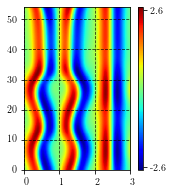

In [2]:
orbit_ = read_h5('OrbitKS_L26p744_T54p129.h5', directory='../data/examples/')
orbit_.plot()

In [3]:
orbit_

OrbitKS({"state_type": "modes", "T": "5.41e+01", "L": "2.67e+01", "N": "32", "M": "32"})

In [8]:
from math import pi

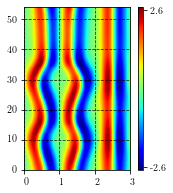

In [12]:
orbit_.rotate(5 / (2*pi*np.sqrt(2)), axis=1).rotate(3, axis=0).plot()

In [13]:
res_list = []
for tmax in np.arange(10, 21):
    clipped_orbit = clip(orbit_.rotate(0.25, axis=1).rotate(10, axis=0), ((0., tmax), (None, None)))
    res_list.append(clipped_orbit.residual())

best_window_max = np.arange(10, 21)[np.argmin(res_list)]
clipped_orbit = clip(orbit_.rotate(0.25, axis=1).rotate(5, axis=0), ((0., best_window_max), (None, None)))


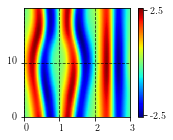

In [16]:
clipped_orbit.plot()

In [18]:
clipped_orbit.T

19.999999999999996

In [20]:
import time

In [23]:
t0 = time.time()
converge_result = converge(clipped_orbit, method='gradient_descent', precision='machine', verbose=True)
t2 = time.time()
print('per iter', ((t2-t0)/converge_result.n_iter)/np.product(clipped_orbit.field_shape))
converged_clipping = converge_result.orbit

Starting gradient descent. Initial residual=0.06578613745662129, target=1e-15, max_iter=6144
############ Residual=0.0012169313893953771 after 1536 gradient descent iterations
############# Residual=0.0010271769455159742 after 3072 gradient descent iterations
############ Residual=0.0009522390411768791 after 4608 gradient descent iterations
############# Residual=0.0008992216299985401 after 6144 gradient descent iterations

Failed to converge. Maximum number of iterations reached. exiting with residual 0.0008992216299985401
per iter 0.48189182025520033


In [37]:
def test_func(orbit_):
    return orbit_.convert(to='modes', inplace=True)

In [35]:
orbit_ = orbit_.convert(to='field')
orbit_

OrbitKS({"state_type": "field", "T": "5.41e+01", "L": "2.67e+01", "N": "32", "M": "32"})

In [38]:
orbit_2 = test_func(orbit_)

In [39]:
orbit_

OrbitKS({"state_type": "modes", "T": "5.41e+01", "L": "2.67e+01", "N": "32", "M": "32"})

In [40]:
orbit_2

OrbitKS({"state_type": "modes", "T": "5.41e+01", "L": "2.67e+01", "N": "32", "M": "32"})

In [30]:
((t2-t0)/converge_result.n_iter)/np.product(clipped_orbit.field_shape)

1.4073042418911225e-05

In [26]:
(t2-t0)

33.20247268676758

In [27]:
converge_result.n_iter 

6144

In [25]:
converge_result.n_iter / (t2-t0)

185.04645897799693

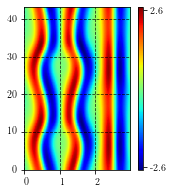

In [20]:
converged_clipping.plot()

In [ ]:
t0 = time.time()
converge_result = converge(clipped_orbit, method='gradient_descent', precision='machine', verbose=True)
t2 = time.time()
print('per iter', converge_result.n_iter / (t2-t0))


For this demonstration, I will use the very first orbit and clipping method I ever applied, which was an iterative procedure to find (converge) a sequence of progressively smaller orbits.

In [ ]:
orbit_.plot()

The structure defined approximately on $t \in [0, 15], x \in [0, 2]$ looks to repeat twice. Therefore this is the target of the clipping. Again, I want to stress that this iterative manner of clipping is now known to be **unnecessary**, but it was how this calculation was originally performed. Orbithunter's utility again shines here via the function 'clip'.

In [6]:
?clip

In [7]:
clip(orbit_, ((0, 15),(0, 2)))

TypeError: unhashable type: 'slice'

In [2]:
orbit1 = read_h5('OrbitKS_L31p245_T46p754.h5')
orbit2 = read_h5('OrbitKS_L26p931_T41p266.h5')
orbit3 = read_h5('OrbitKS_L26p427_T80p246.h5')
orbit4 = read_h5('OrbitKS_L27p038_T23p329.h5')

In [3]:
orbit1 = rediscretize(orbit1, new_shape=(64, 64))

orbit2 = rediscretize(orbit2, new_shape=(64, 64))

orbit3 = rediscretize(orbit3, new_shape=(64, 64))

orbit4 = rediscretize(orbit4, new_shape=(64, 64))

In [4]:
from orbithunter.gluing import tile_dictionary_ks

In [5]:
OrbitKS.dimensions()

['T', 'L']

In [6]:
tile_shape = (64, 64)
tiled_orbit = tile(np.array([[0,1],[1,0]]), tile_shape, tile_dictionary_ks(padded=True), OrbitKS)

TypeError: zip argument #1 must support iteration

In [11]:
iterable_of_orbits = [OrbitKS(T=0.5, L=22), orbit2, orbit3, orbit4]
axis = 0 
# need to iterate over all orbits, find the total dimension and # of points, then create the new_shape tuples.
total_dimension = 0
total_discretization = 0
for o in iterable_of_orbits:
    total_dimension += o.parameters[o.dimensions()[axis]]
    total_discretization += o.parameters['field_shape'][axis]

# Replace the # of points along axis with the rescaled values based upon the total extent of the axis dimension.

new_shapes = [tuple(int(2 * ((((total_discretization * o.parameters[o.dimensions()[axis]]) / total_dimension)+1) // 2))
              if i == axis else o.parameters['field_shape'][i] for i in range(len(o.shape)))
              for o in iterable_of_orbits]
new_shapes

[(0, 32), (64, 64), (124, 64), (36, 64)]

In [8]:
iterable_of_reshaped_orbits = [rediscretize(o, new_shape=shp)
                               for o, shp in zip(iterable_of_orbits, new_shapes)]

In [30]:
total_discretization = 202
total_dimension=179


In [31]:
np.mod([max([2, int(2 * ((((total_discretization * test_dimension) / total_dimension) + 1) // 2))]) for test_dimension in np.arange(1, 200, 0.01)], 2).sum()


0

In [22]:
 int(2 * ((((total_discretization * test_dimension) / total_dimension) + 1) // 2))

58

In [ ]:
converge(tiled_orbit, verbose=True)

In [ ]:
pcc, persistence = orbit_persistence(orbit1)

In [ ]:
gudhi_plot(persistence)